In [6]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

In [7]:
def load_and_preprocess_image(image_path, target_size=(572, 572), normalize=True):
    image = Image.open(image_path)

    image = image.resize(target_size)
    
    # Convert to numpy arrays
    image = np.array(image)

    # Normalize pixel values 
    if normalize:
        image = image / 255.0  # Assuming pixel values are in the range [0, 255]

    return image

In [8]:
def create_dataset(image_path):
    directory_path = image_path
    # Iterate through files in the directory
    image_list =[]
    for filename in os.listdir(directory_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(directory_path, filename)
            images = load_and_preprocess_image(image_path)
            #images = images.reshape(1,images[0],images[1])
            image_list.append(torch.tensor(images).reshape(1,images.shape[0],images.shape[1]))
    images = torch.stack(image_list, dim=0)
    return images

In [9]:
image_path = 'dataset/input/'
#image_path = 'dataset2/input/'
images = create_dataset(image_path)

In [10]:
images.shape

torch.Size([500, 1, 572, 572])

In [11]:
mask_path = 'dataset/output/'
#mask_path = 'dataset2/output/'
masks = create_dataset(mask_path)

In [12]:
masks.shape

torch.Size([500, 1, 572, 572])

In [13]:
images = images.to(torch.float32)
masks = masks.to(torch.float32)

In [14]:
train_size = int(0.80*(len(images)))
train_size

400

In [15]:
train_images = images[:train_size,:,:,:]
train_masks = masks[:train_size,:,:,:]

test_images = images[train_size:,:,:,:]
test_masks = masks[train_size:,:,:,:]

In [16]:
train_images.shape

torch.Size([400, 1, 572, 572])

In [17]:
def double_conv(in_channels,out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding =1, bias ='False'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding = 1, bias = 'False'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True))
    return conv

class UNet(nn.Module):
    
    def __init__(self, in_channels = 1, out_channels = 1):
        super(UNet, self).__init__()
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.down_conv = double_conv(in_channels,64)
        self.down_conv2 = double_conv(64,128)
        self.down_conv3 = double_conv(128,256)
        self.down_conv4 = double_conv(256,512)
        self.down_conv5 = double_conv(512,1024)
        
        self.up_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = double_conv(1024,512)
        
        self.up_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = double_conv(512,256)
        
        self.up_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = double_conv(256,128)
        
        self.up_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = double_conv(128,64)
        
        self.out = nn.Conv2d(64,out_channels, kernel_size=1)
        
        self.softmax = nn.Softmax(dim=1)
    def forward(self, image):
        # encoder
        
        x1_conv = self.down_conv(image)
        x1_pool = self.max_pool(x1_conv)
        
        x2_conv = self.down_conv2(x1_pool)
        x2_pool = self.max_pool(x2_conv)
        
        x3_conv = self.down_conv3(x2_pool)
        x3_pool = self.max_pool(x3_conv)
        
        x4_conv = self.down_conv4(x3_pool)
        x4_pool = self.max_pool(x4_conv)
        
        x5_conv = self.down_conv5(x4_pool)
        
        # Decoder
        x = self.up_trans1(x5_conv)
        x = TF.resize(x, size=x4_conv.shape[2:])
        x = torch.concat((x4_conv,x),axis =1)
        x  = self.up_conv1(x)
        
        x = self.up_trans2(x)
        x = TF.resize(x, size=x3_conv.shape[2:])
        x = torch.concat((x3_conv,x),axis =1)
        x  = self.up_conv2(x)
        
        x = self.up_trans3(x)
        x = TF.resize(x, size=x2_conv.shape[2:])
        x = torch.concat((x2_conv,x),axis =1)
        x  = self.up_conv3(x)
        
        x = self.up_trans4(x)
        x = TF.resize(x, size=x1_conv.shape[2:])
        x = torch.concat((x1_conv,x),axis =1)
        x  = self.up_conv4(x)
        
        x = self.out(x)
        
        #x = self.softmax(x)
        return x
        

In [18]:
model = UNet(1)  
image = torch.randn(1, 1, 572, 572)
print(image[0][0][0][0])
print(image.shape)
output = model(image)
print("Output shape:", output.shape)

tensor(-0.3695)
torch.Size([1, 1, 572, 572])


/Users/balbirsingh/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Output shape: torch.Size([1, 1, 572, 572])


In [19]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

In [65]:
criterion = nn.MSELoss()

#criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr =0.9)

In [66]:
model = UNet(in_channels=1, out_channels=1)  

In [67]:
#pred = model(images[0][0].reshape(1,1,572,572))


In [68]:
#pred

In [69]:
#F.sigmoid(pred).shape

In [70]:
num_epochs = 10
num_batches = 20
batch_size = 20

In [64]:
for epoch in range(1,num_epochs+1):
    for batch in range(1,num_batches+1):
        random_indices = np.random.choice(len(train_images), batch_size, replace=False)
        X = train_images[random_indices]
        y = train_masks[random_indices]
        # 1. forward pass
        y_pred = model(X)

        # 2. loss calculation
        loss = criterion(y_pred,y)

        # 3. Clear up the gradients
        optimizer.zero_grad()

        # 4. back propagations
        loss.backward()

        # 5. gradient descents
        optimizer.step()

        print(f"Batch{batch}-----loss: {loss.item()}")
    if epoch%1==0:
        print(f"epoch{epoch}-----loss: {loss.item()}")

Batch1-----loss: 0.012079634703695774
epoch1-----loss: 0.012079634703695774


In [71]:
from torch.utils.data import DataLoader, TensorDataset

# Define a DataLoader for your training data
train_dataset = TensorDataset(train_images, train_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define your model, optimizer, and criterion here

for epoch in range(1, num_epochs + 1):

    for batch_idx, (X, y) in enumerate(train_loader, 1):
        # 1. Forward pass
        y_pred = model(X)

        # 2. Loss calculation
        loss = criterion(y_pred, y)

        # 3. Clear gradients
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Gradient descent
        optimizer.step()

        if batch_idx % 5 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")
    print(f"epoch {epoch}, Loss: {loss.item()}")

epoch 1, Loss: 0.012004273943603039
epoch 1, Loss: 0.010763317346572876
epoch 1, Loss: 0.010782013647258282
epoch 1, Loss: 0.01059124618768692
Batch 5, Loss: 0.010991803370416164
epoch 1, Loss: 0.010991803370416164
epoch 1, Loss: 0.010719161480665207
epoch 1, Loss: 0.010755431838333607
epoch 1, Loss: 0.011227305047214031
epoch 1, Loss: 0.009973977692425251
Batch 10, Loss: 0.009954508394002914
epoch 1, Loss: 0.009954508394002914
epoch 1, Loss: 0.010803678072988987
epoch 1, Loss: 0.01043771579861641
epoch 1, Loss: 0.011621616780757904
epoch 1, Loss: 0.010154981166124344
Batch 15, Loss: 0.010932469740509987
epoch 1, Loss: 0.010932469740509987
epoch 1, Loss: 0.011201886460185051
epoch 1, Loss: 0.011992618441581726


KeyboardInterrupt: 

In [83]:
# import pickle
# pickle.dump(model,open('model.pkl','wb'))

In [91]:
id = 25

In [123]:
y_test = model(test_images[id].reshape(1,1,images.shape[2],images.shape[3]))
criterion(y_test[0].reshape(1,1,images.shape[2],images.shape[3]), test_masks[id].reshape(1,1,images.shape[2],images.shape[3]))

tensor(0.0102, grad_fn=<MseLossBackward0>)

In [114]:
np.square(test_masks[id]).sum()

tensor(1014.6650)

In [115]:
test_masks.shape

torch.Size([100, 1, 572, 572])

(-0.5, 571.5, 571.5, -0.5)

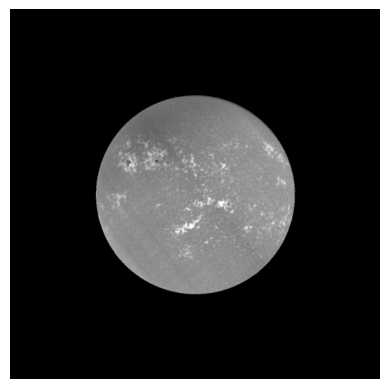

In [135]:
plt.imshow(test_images[id][0],cmap = "gray")
plt.axis('off')

(-0.5, 571.5, 571.5, -0.5)

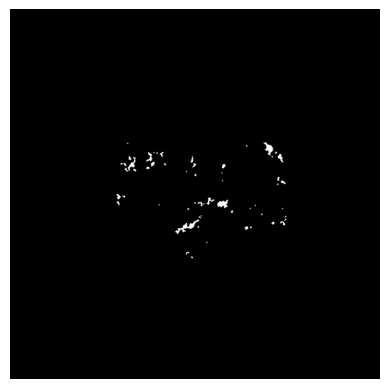

In [136]:
plt.imshow(test_masks[id][0],cmap = 'gray')
plt.axis('off')

In [124]:
y_test = y_test[0][0].detach().numpy()

In [128]:
im = Image.fromarray(y_test).convert('L')

In [126]:
np.unique(im)

array([0.0813358 , 0.08138304, 0.08160423, ..., 0.0926699 , 0.09268755,
       0.09282559], dtype=float32)

In [1]:
plt.imshow(y_test,cmap = 'gray')
plt.axis('off')

NameError: name 'plt' is not defined